In [2]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend" # https://github.com/plaidml/plaidml/blob/master/docs/index.md

from keras.models import Model, Input, save_model, load_model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout # Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
#from keras.preprocessing.image import load_img, img_to_array # requires pip install pillow / import PIL

# keras version still end up import tf.keras version which is incompatible, import directly instead
from tensorflow.keras.callbacks import TensorBoard

Using plaidml.keras.backend backend.


In [4]:
# https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
# Conv2D(batch_size, (input_shape), activation, padding) # more batch size in deeper layer
# MaxPooling2D((input_shape), padding) # padding 'valid' = no padding, padding 'same' = preserve dimension + padding

model_version = 'v9' # getting tired or renaming everytime
dropout_pct = 0.2
input_shape = (128, 128, 3)
encoded_shape = (16, 16, 16)

# Autoencoder Architecture
input_img = Input(shape=input_shape) # change this to other than 28*28 may show "multiple" shape
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(dropout_pct)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(dropout_pct)(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x) # check model.summary() for shape

x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Dropout(dropout_pct)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Dropout(dropout_pct)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) # may want to intentionally drop padding here for other shape
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder Model
autoencoder = Model(input_img, decoded, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='binary_crossentropy') # use binary_crossentropy, mean_squared_error doesnt work
autoencoder.run_eagerly = True # plaidml / keras not running eager mode by default

# Encoder Architecture
Elayer_input = Input(shape=input_shape) # layer start from 0
x = autoencoder.layers[1](Elayer_input)
x = autoencoder.layers[2](x)
x = autoencoder.layers[4](x)
x = autoencoder.layers[5](x)
x = autoencoder.layers[7](x)
Elayer_output = autoencoder.layers[8](x) # extract middle layer

# Encoder Model
encoder = Model(Elayer_input, Elayer_output, name='encoder')

# Decoder Architecture
Dlayer_input = Input(shape=encoded_shape) # use model.summary() to check input_shape
x = autoencoder.layers[-9](Dlayer_input)
x = autoencoder.layers[-8](x)
x = autoencoder.layers[-6](x)
x = autoencoder.layers[-5](x)
x = autoencoder.layers[-3](x)
x = autoencoder.layers[-2](x)
Dlayer_output = autoencoder.layers[-1](x) # extract last layer, start from -1

# Decoder Model
decoder = Model(Dlayer_input, Dlayer_output, name='decoder')

# Remove unused variable to reduce RAM usage
del x, input_img, encoded, decoded, Elayer_input, Elayer_output, Dlayer_input, Dlayer_output

In [5]:
# way too much training parameters, dense is too exhaustive and little benefit even though simple
autoencoder.summary()
encoder.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 32)        0         
__________

In [6]:
def make_square(img):
    cols,rows = img.size
    
    if rows>cols:
        pad = (rows-cols)/4
        img = img.crop((0, pad, cols, cols+pad)) # left, up, right, down
    else:
        pad = (cols-rows)/4
        img = img.crop((pad, 0, rows+pad, rows))
    
    return img # make centered square image

In [8]:
%%time
target_length_size = 128
#target_image_size = (target_length_size, target_length_size)

# Check training dataset image # no longer needed
'''
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

path_train = r'D:\Public\fyp-code\datasets\coco\train2017-2'

train_data = []

for img in sorted(os.listdir(path_train)):
    #print(img) # show which image file currently used
    
    # Keras builtin (not used)
    #x = load_img(os.path.join(path_train,img), target_size=(128,128), color_mode='grayscale') 
    #x = img_to_array(x)
    
    # PIL (use this)
    x = Image.open(os.path.join(path_train,img))
    display(x) # show training image
    print('Original image size is ' + str(x.size))
    x = make_square(x)
    display(x) # show square image
    print('Squared image size is ' + str(x.size))
    x = x.resize(target_length_size) # TAKE NOTE
    x = np.asarray(x)
    x = x.astype('float32')/255
    train_data.append(np.asarray(x)) # can take a long time
    print(str(len(train_data)) + ' of ' + str(len(os.listdir(path_train))))
    break

print('train_data type is ' + str(type(train_data)))
print('train_data shape is '+ str(np.asarray(train_data).shape)) # type list has no shape, must be in type array # (1, 128, 128, 3)
print('image type in train_data is ' + str(type(train_data[0])))
plt.imshow(np.squeeze(train_data[0])) # show resized 1st image
plt.show()

# Remove unused variable to reduce RAM usage
del x
'''

Wall time: 0 ns


"\nimport os\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom PIL import Image\nfrom IPython.display import display\n\npath_train = r'D:\\Public\x0cyp-code\\datasets\\coco\train2017-2'\n\ntrain_data = []\n\nfor img in sorted(os.listdir(path_train)):\n    #print(img) # show which image file currently used\n    \n    # Keras builtin (not used)\n    #x = load_img(os.path.join(path_train,img), target_size=(128,128), color_mode='grayscale') \n    #x = img_to_array(x)\n    \n    # PIL (use this)\n    x = Image.open(os.path.join(path_train,img))\n    display(x) # show training image\n    print('Original image size is ' + str(x.size))\n    x = make_square(x)\n    display(x) # show square image\n    print('Squared image size is ' + str(x.size))\n    x = x.resize(target_length_size) # TAKE NOTE\n    x = np.asarray(x)\n    x = x.astype('float32')/255\n    train_data.append(np.asarray(x)) # can take a long time\n    print(str(len(train_data)) + ' of ' + str(len(os.listdir(path_train))))\

In [9]:
# Refer "Dataset Preprocess to Pickle - COCO train2017.ipynb" for data preprocess
# We will directly load preprocessed datasets rather than load jpg one by one

In [12]:
%%time
import pickle as pkl

with open(f'datasets_coco_train2017_{target_length_size}.pkl', 'rb') as handle:
    print(f'Opening datasets_coco_train2017_{target_length_size}.pkl')
    train_data = pkl.load(handle)
    print('Done')

with open(f'datasets_coco_test2017_{target_length_size}.pkl', 'rb') as handle:
    print(f'Opening datasets_coco_test2017_{target_length_size}.pkl')
    test_data = pkl.load(handle)
    print('Done')

with open(f'datasets_coco_val2017_{target_length_size}.pkl', 'rb') as handle:
    print(f'Opening datasets_coco_val2017_{target_length_size}.pkl')
    val_data = pkl.load(handle)
    print('Done')

Opening datasets_coco_train2017_128.pkl
Done
Opening datasets_coco_test2017_128.pkl
Done
Opening datasets_coco_val2017_128.pkl
Done
Wall time: 59.5 s


In [13]:
%%time
#train_data = np.reshape(train_data, (len(train_data), 128, 128, 3))
#test_data = np.reshape(test_data, (len(test_data), 128, 128, 3))
#val_data = np.reshape(val_data, (len(val_data), 128, 128, 3))
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(14785, 128, 128, 3)
(5083, 128, 128, 3)
(625, 128, 128, 3)
Wall time: 991 µs


In [14]:
%%time
# we need to flatten images for basic neural network input
#train_data = train_data.reshape(len(train_data), (np.prod(train_data.shape[1:]))) # 64x64 flatten into 12288
#test_data  = test_data.reshape(len(test_data), (np.prod(test_data.shape[1:])))

print(f'train_data shape = {train_data.shape}') # 14785 images 12288 vectors = 14785 row 12288 col
print(f'test_data shape = {test_data.shape}') # 5083 images 12288 vectors = 5083 row 12288 col

train_data shape = (14785, 128, 128, 3)
test_data shape = (5083, 128, 128, 3)
Wall time: 0 ns


In [15]:
%%time
# Resume by load_model (example)
#autoencoder = load_model(f'autoencoder{model_version}/checkpoint/model.02-0.53.h5') # use this
#latest = tf.train.latest_checkpoint(f'autoencoder{model_version}/checkpoint') # TODO

Wall time: 0 ns


In [16]:
%%time
import os

try:
    os.makedirs(f'autoencoder{model_version}/logs')
except Exception:
    pass

try:
    os.makedirs(f'autoencoder{model_version}/checkpoint')
except Exception:
    pass

# Run this in a terminal (unfortunate cant rename this one on the fly)
#tensorboard --logdir=autoencoderv9/logs

callbacks=[
    TensorBoard(log_dir=f'autoencoder{model_version}/logs'),
    ModelCheckpoint(filepath=f'autoencoder{model_version}/checkpoint' + '/' + 'model.{epoch:003d}-{val_loss:.4f}.h5',
                    verbose=1, save_best_only=True, mode='min'),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) # patience=10
]

initial_epoch = 0 # set this to something else if want to resume training

# Fit data # If it takes a long time to show Epoch 1, check your input shape # WARINING: RAM will rise
training = autoencoder.fit(train_data, train_data,
                           validation_data=(test_data, test_data),
                           epochs=100, batch_size=50, shuffle=True, initial_epoch=initial_epoch,
                           callbacks=callbacks)

Train on 14785 samples, validate on 5083 samples
Epoch 1/100


INFO:plaidml:Analyzing Ops: 40 of 442 operations complete
INFO:plaidml:Analyzing Ops: 91 of 442 operations complete
INFO:plaidml:Analyzing Ops: 132 of 442 operations complete
INFO:plaidml:Analyzing Ops: 145 of 442 operations complete
INFO:plaidml:Analyzing Ops: 165 of 442 operations complete
INFO:plaidml:Analyzing Ops: 177 of 442 operations complete


14750/14785 [============================>.] - ETA: 3s - loss: 0.5662

INFO:plaidml:Analyzing Ops: 69 of 442 operations complete
INFO:plaidml:Analyzing Ops: 132 of 442 operations complete
INFO:plaidml:Analyzing Ops: 145 of 442 operations complete
INFO:plaidml:Analyzing Ops: 165 of 442 operations complete
INFO:plaidml:Analyzing Ops: 177 of 442 operations complete
INFO:plaidml:Analyzing Ops: 45 of 118 operations complete
INFO:plaidml:Analyzing Ops: 74 of 118 operations complete
INFO:plaidml:Analyzing Ops: 54 of 118 operations complete


14785/14785 [==============================] - 1821s 123ms/step - loss: 0.5661 - val_loss: 0.6071

Epoch 00001: val_loss improved from inf to 0.60711, saving model to autoencoderv9/checkpoint/model.001-0.6071.h5
Epoch 2/100
14785/14785 [==============================] - 1994s 135ms/step - loss: 0.5471 - val_loss: 0.5917

Epoch 00002: val_loss improved from 0.60711 to 0.59172, saving model to autoencoderv9/checkpoint/model.002-0.5917.h5
Epoch 3/100
14785/14785 [==============================] - 1936s 131ms/step - loss: 0.5442 - val_loss: 0.5794

Epoch 00003: val_loss improved from 0.59172 to 0.57939, saving model to autoencoderv9/checkpoint/model.003-0.5794.h5
Epoch 4/100
14785/14785 [==============================] - 1722s 116ms/step - loss: 0.5426 - val_loss: 0.5730

Epoch 00004: val_loss improved from 0.57939 to 0.57302, saving model to autoencoderv9/checkpoint/model.004-0.5730.h5
Epoch 5/100
14785/14785 [==============================] - 1759s 119ms/step - loss: 0.5415 - val_loss: 0

In [41]:
%%time
import os

try:
    os.makedirs(f'autoencoder{model_version}/model')
except Exception:
    pass

save_model(autoencoder, f'autoencoder{model_version}/model/autoencoder{model_version}-last_train.h5')
save_model(encoder, f'autoencoder{model_version}/model/encoder{model_version}-last_train.h5')
save_model(decoder, f'autoencoder{model_version}/model/decoder{model_version}-last_train.h5')

Wall time: 878 ms


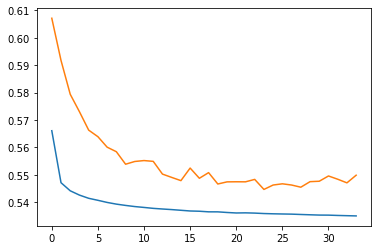

Wall time: 5.03 s


In [17]:
%%time
# need to put training = autoencoder.fit(...) first
import matplotlib.pyplot as plt

plt.plot(training.history['loss'], label='train')
plt.plot(training.history['val_loss'], label='test')
plt.show()

In [18]:
%%time
#val_data  = val_data.reshape(len(val_data), (np.prod(val_data.shape[1:])))
print(f'x_test shape = {val_data.shape}')

encoded_imgs = encoder.predict(val_data)
decoded_imgs = decoder.predict(encoded_imgs)

x_test shape = (625, 128, 128, 3)


INFO:plaidml:Analyzing Ops: 20 of 28 operations complete
INFO:plaidml:Analyzing Ops: 18 of 45 operations complete
INFO:plaidml:Analyzing Ops: 28 of 45 operations complete


Wall time: 31.4 s


(128, 128, 3)


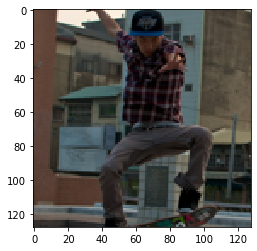

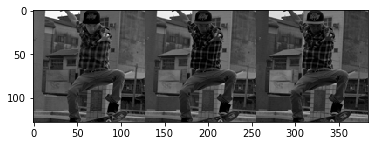

(16, 16, 16)


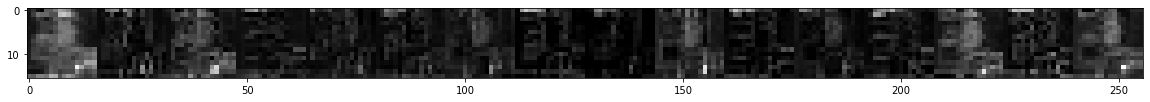

(128, 128, 3)


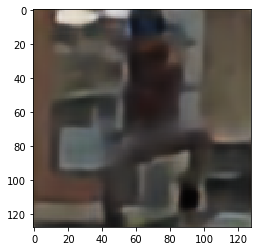

In [95]:
from matplotlib import pyplot as plt

i = 624

print(val_data[i].shape)
plt.imshow(val_data[i], interpolation='nearest')
plt.show()

# test transpose
#plt.imshow(val_data[i].T, interpolation='nearest') # TypeError: Invalid shape (3, 128, 128) for image data
#plt.show()
#plt.imshow(val_data[i].T.reshape(128*3,128), interpolation='nearest')
#plt.show()
plt.imshow(val_data[i].T.reshape(128*3,128).T, interpolation='nearest')
plt.show()

plt.figure(figsize=(20, 8))
print(encoded_imgs[i].shape)
plt.imshow(encoded_imgs[i].T.reshape(16 * 16, 16).T, interpolation='nearest')
plt.show()

print(decoded_imgs[i].shape)
plt.imshow(decoded_imgs[i], interpolation='nearest')
plt.show()

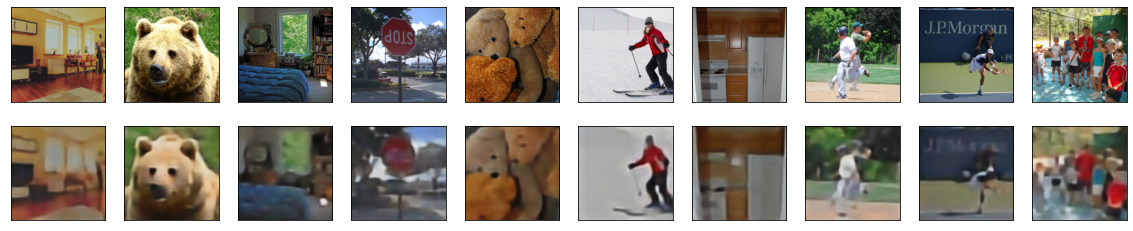

69.3
67.0
69.6
67.2
71.7
63.7
70.4
66.5
69.1
66.0
Wall time: 2.19 s


In [30]:
%%time
# result of training with dropout after maxpool and upsample and test them with dropouts removed
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(val_data[i].reshape(input_shape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(input_shape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

# https://dsp.stackexchange.com/questions/38065/peak-signal-to-noise-ratio-psnr-in-python-for-an-image
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

n = 10
for i in range(n):
    original = val_data[i]
    contrast = decoded_imgs[i]
    d=psnr(original,contrast) # can also use cv2.PSNR rather than defined function psnr
    print('%.1f' % d)

In [96]:
# in case the result is bad, try checkout the last best possible network

# Resume by load model (example)
autoencoder = load_model(f'autoencoderv9/checkpoint/model.024-0.5447.h5') # use this
#latest = tf.train.latest_checkpoint(f'autoencoder{model_version}/checkpoint') # TODO

# Encoder Architecture
Elayer_input = Input(shape=input_shape) # layer start from 0
x = autoencoder.layers[1](Elayer_input)
x = autoencoder.layers[2](x)
x = autoencoder.layers[4](x)
x = autoencoder.layers[5](x)
x = autoencoder.layers[7](x)
Elayer_output = autoencoder.layers[8](x) # extract middle layer

# Encoder Model
encoder = Model(Elayer_input, Elayer_output, name='encoder')

# Decoder Architecture
Dlayer_input = Input(shape=encoded_shape) # use model.summary() to check input_shape
x = autoencoder.layers[-9](Dlayer_input)
x = autoencoder.layers[-8](x)
x = autoencoder.layers[-6](x)
x = autoencoder.layers[-5](x)
x = autoencoder.layers[-3](x)
x = autoencoder.layers[-2](x)
Dlayer_output = autoencoder.layers[-1](x) # extract last layer, start from -1

# Decoder Model
decoder = Model(Dlayer_input, Dlayer_output, name='decoder')

# Remove unused variable to reduce RAM usage
del x, Elayer_input, Elayer_output, Dlayer_input, Dlayer_output

encoded_imgs = encoder.predict(val_data)
decoded_imgs = decoder.predict(encoded_imgs)

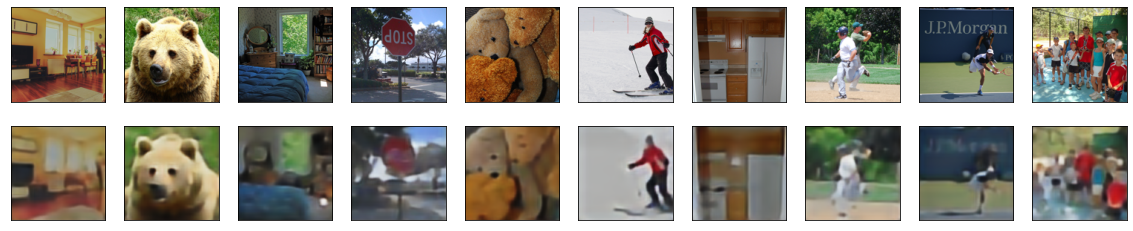

70.2
67.9
69.5
67.6
71.3
64.6
71.0
67.4
69.7
66.5
Wall time: 1.26 s


In [97]:
%%time
# result of training with dropout after maxpool and upsample and test them with dropouts removed
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(val_data[i].reshape(input_shape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(input_shape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

# https://dsp.stackexchange.com/questions/38065/peak-signal-to-noise-ratio-psnr-in-python-for-an-image
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

n = 10
for i in range(n):
    original = val_data[i]
    contrast = decoded_imgs[i]
    d=psnr(original,contrast) # can also use cv2.PSNR rather than defined function psnr
    print('%.1f' % d)

(128, 128, 3)


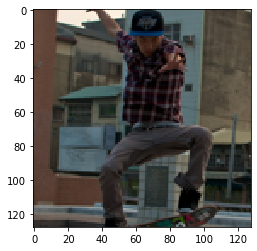

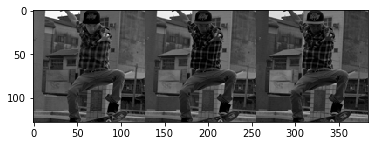

(16, 16, 16)


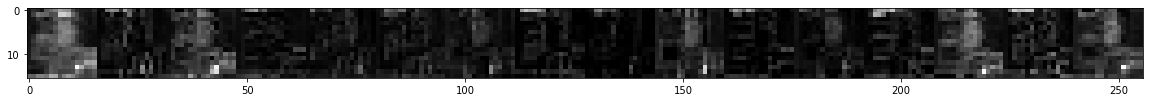

(128, 128, 3)


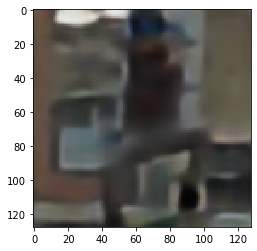

In [98]:
from matplotlib import pyplot as plt

i = 624

print(val_data[i].shape)
plt.imshow(val_data[i], interpolation='nearest')
plt.show()

# test transpose
#plt.imshow(val_data[i].T, interpolation='nearest') # TypeError: Invalid shape (3, 128, 128) for image data
#plt.show()
#plt.imshow(val_data[i].T.reshape(128*3,128), interpolation='nearest')
#plt.show()
plt.imshow(val_data[i].T.reshape(128*3,128).T, interpolation='nearest')
plt.show()

plt.figure(figsize=(20, 8))
print(encoded_imgs[i].shape)
plt.imshow(encoded_imgs[i].T.reshape(16 * 16, 16).T, interpolation='nearest')
plt.show()

print(decoded_imgs[i].shape)
plt.imshow(decoded_imgs[i], interpolation='nearest')
plt.show()

In [ ]:
'''
%%time
# in case the result is bad, try checkout the last best possible network

# Resume by load model (example)
#autoencoder = load_model(f'autoencoder{model_version}/checkpoint/model.004-0.644.h5') # use this
#latest = tf.train.latest_checkpoint(f'autoencoder{model_version}/checkpoint') # TODO

# Encoder Architecture
Elayer_input = Input(shape=input_shape) # layer start from 0
x = autoencoder.layers[1](Elayer_input)
x = autoencoder.layers[2](x)
x = autoencoder.layers[4](x)
x = autoencoder.layers[5](x)
x = autoencoder.layers[7](x)
Elayer_output = autoencoder.layers[8](x) # extract middle layer

# Encoder Model
encoder = Model(Elayer_input, Elayer_output, name='encoder')

# Decoder Architecture
Dlayer_input = Input(shape=encoded_shape) # use model.summary() to check input_shape
x = autoencoder.layers[-9](Dlayer_input)
x = autoencoder.layers[-8](x)
x = autoencoder.layers[-6](x)
x = autoencoder.layers[-5](x)
x = autoencoder.layers[-3](x)
x = autoencoder.layers[-2](x)
Dlayer_output = autoencoder.layers[-1](x) # extract last layer, start from -1

# Decoder Model
decoder = Model(Dlayer_input, Dlayer_output, name='decoder')

# Remove unused variable to reduce RAM usage
del x, Elayer_input, Elayer_output, Dlayer_input, Dlayer_output

encoded_imgs = encoder.predict(val_data)
decoded_imgs = decoder.predict(encoded_imgs)
'''
'''
autoencoder.summary()
encoder.summary()
decoder.summary()
'''
'''
%%time
# result here
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(val_data[i].reshape(input_shape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(input_shape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

# https://dsp.stackexchange.com/questions/38065/peak-signal-to-noise-ratio-psnr-in-python-for-an-image
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

n = 10
for i in range(n):
    original = val_data[i]
    contrast = decoded_imgs[i]
    d=psnr(original,contrast) # can also use cv2.PSNR rather than defined function psnr
    print('%.1f' % d)
'''

In [99]:
%%time
# conclusion: training with a few dropout can improve the network, saving for now
import os

try:
    os.makedirs(f'autoencoder{model_version}/model')
except Exception:
    pass

save_model(autoencoder, f'autoencoder{model_version}/model/autoencoder{model_version}-best.h5')
save_model(encoder, f'autoencoder{model_version}/model/encoder{model_version}-best.h5')
save_model(decoder, f'autoencoder{model_version}/model/decoder{model_version}-best.h5')

Wall time: 1.25 s


In [3]:
autoencoder = load_model(f'autoencoder{model_version}/model/autoencoder{model_version}-best.h5')
encoder = load_model(f'autoencoder{model_version}/model/encoder{model_version}-best.h5')
decoder = load_model(f'autoencoder{model_version}/model/decoder{model_version}-best.h5')

NameError: name 'model_version' is not defined